In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import operator
import scipy.stats
from scipy.stats.stats import pearsonr

import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt

import os
from bokeh.plotting import figure, output_file
from bokeh.io import output_notebook, show, export_png, export_svgs
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh import palettes
import bokeh.models as bmo

import seaborn as sns

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
data_path = '../data/'

In [4]:
path_to_datasets = data_path + 'related_datasets/'

In [5]:
inputs_path = data_path + 'inputs/'
base_path = inputs_path + 'Base/'

# Import & Join datasets

## Sufficiencies

In [9]:
path_to_suff = os.path.join(path_to_datasets,'sufficiencies_input.csv')
suff = pd.read_csv(path_to_suff).drop(['Unnamed: 0', 'get_below', 'plot'], axis=1)

In [10]:
# Cases: all_ssp column
#0: down in all scenario 
#1: down in most scenario 
#2: variable 
#3: up in most scenario 
#4: up in all scenario
suff = suff.rename({'all_ssp': 'delta_consistency'}, axis=1)

In [11]:
suff.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0


In [12]:
len(suff)

166

## Import independency

In [13]:
path_to_gpck = os.path.join(path_to_datasets,'Import_independency/Matti_Kummu_2019/shp_trade_dep.gpkg')
import_indep = gpd.read_file(path_to_gpck)#, layer='countries')

In [14]:
imports_data = import_indep[['cntry', 'admin','country','yr2013']]
imports_data.head()

,cntry,admin,country,yr2013
0,None,Saint Barthelemy,None,NaN
1,None,Jersey,None,NaN
2,None,Ashmore and Cartier Islands,None,NaN
3,None,Siachen Glacier,None,NaN
4,None,Indian Ocean Territories,None,NaN


In [15]:
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries_names.head()

,id,ISO3,adm0_a3,name,nev_admin_name,fao_producer_prices_name,nev_name,nev_name_long,sovereignt,base_id,...,iana_internet,un_vehicle,ioc_olympic,un_iso_numeric,itu_calling,UNI,UNDP,FAOSTAT,GAU,FAOSTAT_augmented
0,1,ABW,ABW,Aruba,Aruba,Aruba,Aruba,Aruba,Netherlands,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1533
1,2,AFG,AFG,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,1,...,.af,AFG,AFG,4.0,93,4.0,AFG,2.0,1.0,2
2,3,AGO,AGO,Angola,Angola,Angola,Angola,Angola,Angola,2,...,.ao,NaN,ANG,24.0,244,24.0,ANG,7.0,8.0,7
3,4,AIA,AIA,Anguilla,Anguilla,Anguilla,Anguilla,Anguilla,United Kingdom,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1660
4,5,ALB,ALB,Albania,Albania,Albania,Albania,Albania,Albania,4,...,.al,AL,ALB,8.0,355,8.0,ALB,3.0,3.0,3


In [16]:
# merge import with country_names to add ISO3 columns
imports = imports_data.merge(countries_names[['ISO3', 'name']], left_on='admin', right_on='name', how='right')
imports.head()

,cntry,admin,country,yr2013,ISO3,name
0,None,Saint Barthelemy,None,NaN,BLM,Saint Barthelemy
1,None,Jersey,None,NaN,JEY,Jersey
2,None,Siachen Glacier,None,NaN,KAS,Siachen Glacier
3,None,Indian Ocean Territories,None,NaN,IOA,Indian Ocean Territories
4,None,South Georgia and South Sandwich Islands,None,NaN,SGS,South Georgia and South Sandwich Islands


In [17]:
# Join with Sufficiencies
sufficiencies = suff.merge(imports, on='ISO3').drop(['admin', 'country', 'cntry'], axis=1)
sufficiencies = sufficiencies.rename({'yr2013': 'trade_dep_2013'}, axis=1)
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,Afghanistan
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,Angola
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,Albania
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,Argentina


In [18]:
# Check number of countries where we have no info about trade
len(suff), len(sufficiencies.dropna(how='any'))

(166, 148)

In [19]:
# Check which country it is
nan = [c for c in list(suff['ISO3']) if c not in list(sufficiencies.dropna(how='any')['ISO3'])]
nan

['BDI',
 'BTN',
 'CIV',
 'COD',
 'ERI',
 'GNQ',
 'LBY',
 'OMN',
 'PNG',
 'PRI',
 'PSX',
 'SDS',
 'SGP',
 'SOL',
 'SOM',
 'SRB',
 'SYR',
 'TZA']

In [20]:
set(countries_names[countries_names['ISO3'].isin(nan)]['name'].values)

{'Bhutan',
 'Burundi',
 'Democratic Republic of the Congo',
 'Equatorial Guinea',
 'Eritrea',
 'Ivory Coast',
 'Libya',
 'Oman',
 'Palestine',
 'Papua New Guinea',
 'Puerto Rico',
 'Serbia',
 'Singapore',
 'Somalia',
 'Somaliland',
 'South Sudan',
 'Syria',
 'Tanzania'}

## Water Security 

* **Source**: Brauman, K. A., B. D. Richter, S. Postel, M. Malsy and M. Flörke (2016). "Water depletion: An improved metric for incorporating seasonal and dry-year water scarcity into water risk assessments." Elementa: Science of the Anthropocene 4(1): 000083

* **Aggregation by country**: aggregate it by country as the %area in any of the depleted category (i.e Categories: 5 to 8 )—> Looking at column OrigDepletionCategory


In [11]:
path_to_tif = os.path.join(path_to_datasets,'Water_Security/GlobalWaterScarcity/DepletionMapCurrent.tif')

In [12]:
from osgeo import gdal
raster = gdal.Open(path_to_tif)
gt = raster.GetGeoTransform()
print(gt)
pixelSizeX = gt[1]
pixelSizeY =-gt[5]

pixelSizeX, pixelSizeY

(-180.0, 0.0833333333333286, 0.0, 89.99999999998977, 0.0, -0.0833333333333286)


(0.0833333333333286, 0.0833333333333286)

In [82]:
# tif to tabular
#! gdal_translate data/related_datasets/Water_Security/GlobalWaterScarcity/DepletionMapCurrent.tif data/related_datasets/Water_Security/GlobalWaterScarcity/DepletionMapCurrent.xyz

In [21]:
file = pd.read_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'DepletionMapCurrent.xyz', delimiter=' ', header=None)
new_df = pd.DataFrame(file[2].values, columns=['water_sec'])
#new_df.to_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'water_security.csv')

In [22]:
# Aggregate
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv', encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
countries = countries.set_index('pixel_id')

water_sec = pd.read_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'water_security.csv', index_col=0)
water_sec.index.name = 'pixel_id'
water_sec_countries = water_sec.join(countries, on='pixel_id').dropna()

/Users/Romain/anaconda3/envs/food_sufficiency/lib/python3.8/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
# count number of values in each category per country
diff_water_sec_countries = water_sec_countries.groupby(['ISO3', 'water_sec'])['water_sec'].count().rename('water_sec_count').reset_index(level=1)
# keep only categories >= 5 and sum value counts per country
interesting = diff_water_sec_countries[diff_water_sec_countries['water_sec'] >= 5].groupby('ISO3')['water_sec_count'].sum()

# total number of values per country
total_water_sec_countries = water_sec_countries.groupby(['ISO3'])['ISO3'].count().rename('total_count')

# compute water sec val
joined = pd.concat([interesting, total_water_sec_countries], axis=1, sort=False)
joined['water_sec'] = joined['water_sec_count'] / joined['total_count']
joined.index.name = 'ISO3'

In [24]:
# Join water data and sufficiencies
sufficiencies = sufficiencies.merge(joined['water_sec'], on='ISO3')

In [25]:
len(sufficiencies)

166

## Food Security
* Dataset: GFSI -- Global Food Security Index 2018, for 113 countries
* Source: EIU Global Food Security Index 2018 Building resilience in the face of rising food-security risks, 2018



In [26]:
path_to_file = os.path.join(path_to_datasets,'Food_Security/GFSI_2018_min.csv')
food_secu = pd.read_excel(path_to_file)

In [27]:
food_secu.head()

,Country_name,GFSI_2018
0,Singapore,85.9
1,Ireland,85.5
2,United Kingdom,85.0
3,United States,85.0
4,Netherlands,84.7


In [28]:
food_secu['GFSI_2018'] = food_secu['GFSI_2018']/100

In [29]:
len(food_secu)

113

In [30]:
## Join with Sufficiencies
sufficiencies = sufficiencies.merge(food_secu, left_on='name', right_on='Country_name', how='left').drop('Country_name', axis=1)

In [31]:
len(sufficiencies)

166

## Malnutrition
To download from https://data.worldbank.org/indicator/SH.STA.MALN.ZS


In [32]:
malnutrition_data = pd.read_csv(path_to_datasets + 'Malnutrition/API_SH.STA.MALN.ZS_DS2_en_csv_v2_49604.csv', header=2)
# get last valid value (transpose than ffill than retranspose)
malnutrition_filled = malnutrition_data.T.fillna(method='ffill').T[['Country Code', '2018']].set_index('Country Code')
malnutrition_filled.index.name = 'ISO3'
# keep only numerical values
malnutrition_df = malnutrition_filled[malnutrition_filled['2018'].apply(lambda x: type(x) == float)].rename({'2018': 'malnutrition'}, axis=1)/100

In [33]:
cols = [str(x) for x in list(range(1960, 2018))]

In [34]:
# Get years where data is taken from
years = set()
for i, row in malnutrition_data.iterrows():
    for y in row[cols].dropna().index:
        years.add(y)
years = list(years)
years.sort(reverse=True)

In [35]:
# Map years to countries
c = list(sufficiencies['ISO3'].values)
print(len(c))
data = {}
for year in years:
    vals_year = malnutrition_data[malnutrition_data['Country Code'].isin(c)][[year, 'Country Code']].dropna()
    c_years = list(vals_year['Country Code'])
    if len(c_years) > 0:
        data[year] = c_years
    for y in c_years:
        try:
            c.remove(y)
        except ValueError:
            pass

data

166


{'2016': ['AGO',
  'ARM',
  'BDI',
  'BFA',
  'BOL',
  'CIV',
  'ETH',
  'GIN',
  'LKA',
  'MMR',
  'MYS',
  'NER',
  'NGA',
  'NPL',
  'PER',
  'PRY',
  'SEN',
  'THA',
  'UGA',
  'ZAF'],
 '2015': ['BLZ',
  'COG',
  'GTM',
  'IND',
  'KAZ',
  'MEX',
  'MLI',
  'MRT',
  'MWI',
  'PHL',
  'RWA',
  'TCD',
  'TKM',
  'TZA',
  'VNM',
  'ZWE'],
 '2014': ['BEN',
  'BGD',
  'CHL',
  'CMR',
  'ECU',
  'EGY',
  'GHA',
  'GNB',
  'GUY',
  'JAM',
  'KEN',
  'KGZ',
  'KHM',
  'KWT',
  'LSO',
  'OMN',
  'SDN',
  'SLV',
  'SRB',
  'SWZ',
  'TGO'],
 '2013': ['AFG',
  'AZE',
  'CHN',
  'COD',
  'DOM',
  'GMB',
  'IDN',
  'LBR',
  'MNE',
  'MNG',
  'NAM',
  'SLE',
  'TLS',
  'TUR',
  'YEM',
  'ZMB'],
 '2012': ['BIH',
  'DJI',
  'DZA',
  'GAB',
  'HND',
  'HTI',
  'JOR',
  'MDA',
  'NIC',
  'PAK',
  'PRK',
  'TJK',
  'TUN',
  'USA'],
 '2011': ['GNQ', 'IRN', 'IRQ', 'LAO', 'MAR', 'MKD', 'MOZ', 'TTO', 'URY'],
 '2010': ['BTN', 'CAF', 'COL', 'ERI', 'JPN', 'KOR', 'PNG', 'SUR'],
 '2009': ['ALB', 'BRN', 'GEO', 

In [36]:
# Join 
sufficiencies = sufficiencies.join(malnutrition_df, how='left', on='ISO3')

## GDP

In [37]:
gdp_data = pd.read_csv(path_to_datasets + 'GDP_WorldBank_2018/' + 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_41089.csv', header=2).rename({'Country Code': 'ISO3'}, axis=1)
gdp_data.head()

,Country Name,ISO3,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,23512.602596,24985.993281,24713.698045,25025.099563,25533.569780,25796.380251,25239.600411,25630.266492,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,101.108305,...,543.303042,591.162346,641.872034,637.165044,613.856333,578.466353,547.228110,556.302139,520.896603,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3587.883798,4615.468028,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3432.385736,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4094.358816,4437.177794,4247.614342,4413.082887,4578.667934,3952.830781,4124.108543,4532.889198,5253.630064,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,39736.354063,41100.729938,38392.943901,40626.751632,42300.334128,36039.653496,37224.108916,39134.393371,42029.762737,NaN


In [38]:
gdp = gdp_data[['ISO3', '2018']].rename({'2018': 'GDP'}, axis=1)
gdp.head()

,ISO3,GDP
0,ABW,NaN
1,AFG,520.896603
2,AGO,3432.385736
3,ALB,5253.630064
4,AND,42029.762737


In [39]:
sufficiencies = sufficiencies.merge(gdp, on='ISO3')

In [40]:
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name,water_sec,GFSI_2018,malnutrition,GDP
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,Afghanistan,0.652642,NaN,0.25,520.896603
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,Angola,0.010298,0.386,0.19,3432.385736
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,Albania,0.390023,NaN,0.063,5253.630064
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,0.998895,0.725,NaN,43004.948646
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,Argentina,0.195395,0.692,0.023,11652.566290


In [41]:
sufficiencies['log_GDP'] = sufficiencies['GDP'].apply(lambda x: np.log(x))

## GNI

In [42]:
gnp_data = pd.read_csv(path_to_datasets + 'GNP_WorldBank_2018/' + 'API_NY.GNP.PCAP.CD_DS2_en_csv_v2_41922.csv', header=2).rename({'Country Code': 'ISO3'}, axis=1)
gnp_data.head()

,Country Name,ISO3,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,22370.0,22450.0,23520.0,23970.0,24500.0,23780.0,23550.0,23630.0,NaN,NaN
1,Afghanistan,AFG,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,510.0,530.0,630.0,660.0,630.0,600.0,570.0,550.0,550.0,NaN
2,Angola,AGO,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3240.0,3420.0,4170.0,4780.0,5010.0,4520.0,3770.0,3560.0,3370.0,NaN
3,Albania,ALB,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4360.0,4410.0,4360.0,4540.0,4540.0,4390.0,4320.0,4290.0,4860.0,NaN
4,Andorra,AND,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
gnp = gnp_data[['ISO3', '2018']].rename({'2018': 'GNP'}, axis=1)
gnp.head()

,ISO3,GNP
0,ABW,NaN
1,AFG,550.0
2,AGO,3370.0
3,ALB,4860.0
4,AND,NaN


In [44]:
sufficiencies = sufficiencies.merge(gnp, on='ISO3')

In [45]:
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name,water_sec,GFSI_2018,malnutrition,GDP,log_GDP,GNP
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,Afghanistan,0.652642,NaN,0.25,520.896603,6.255552,550.0
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,Angola,0.010298,0.386,0.19,3432.385736,8.141011,3370.0
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,Albania,0.390023,NaN,0.063,5253.630064,8.566675,4860.0
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,0.998895,0.725,NaN,43004.948646,10.669070,41010.0
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,Argentina,0.195395,0.692,0.023,11652.566290,9.363282,12370.0


In [46]:
sufficiencies['log_GNP'] = sufficiencies['GNP'].apply(lambda x: np.log(x))

In [47]:
gnp_income_group = pd.read_csv(path_to_datasets + 'GNP_WorldBank_2018/' + 'Metadata_Country_API_NY.GNP.PCAP.CD_DS2_en_csv_v2_41922.csv').rename({'Country Code': 'ISO3'}, axis=1)
gnp_income_group = gnp_income_group[['ISO3', 'IncomeGroup']]
gnp_income_group.head()

,ISO3,IncomeGroup
0,ABW,High income
1,AFG,Low income
2,AGO,Lower middle income
3,ALB,Upper middle income
4,AND,High income


In [48]:
set(gnp_income_group['IncomeGroup'].values)

{'High income',
 'Low income',
 'Lower middle income',
 'Upper middle income',
 nan}

In [49]:
sufficiencies = sufficiencies.merge(gnp_income_group, on='ISO3')

In [50]:
#sufficiencies.to_csv(path_to_datasets + 'sufficiencies_added_data.csv', index=False)

In [51]:
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade_dep_2013,name,water_sec,GFSI_2018,malnutrition,GDP,log_GDP,GNP,log_GNP,IncomeGroup
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,Afghanistan,0.652642,NaN,0.25,520.896603,6.255552,550.0,6.309918,Low income
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,Angola,0.010298,0.386,0.19,3432.385736,8.141011,3370.0,8.122668,Lower middle income
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,Albania,0.390023,NaN,0.063,5253.630064,8.566675,4860.0,8.488794,Upper middle income
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,0.998895,0.725,NaN,43004.948646,10.669070,41010.0,10.621571,High income
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,Argentina,0.195395,0.692,0.023,11652.566290,9.363282,12370.0,9.423029,Upper middle income


In [52]:
len(sufficiencies)

160

## Countries dropped during process

In [53]:
path_to_suff = os.path.join(path_to_datasets,'sufficiencies_input.csv')
old_suff = pd.read_csv(path_to_suff).drop(['Unnamed: 0', 'get_below'], axis=1)
new_suff = pd.read_csv(path_to_datasets + 'sufficiencies_added_data.csv')

In [54]:
old_c = set(old_suff['ISO3'])
new_c = set(new_suff['ISO3'])

dropped = list(old_c - new_c)

In [55]:
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1', index_col='ISO3')
countries_names.loc[dropped, 'name'].values

array(['South Sudan', 'Somaliland', 'Kosovo', 'Palestine',
       'Northern Cyprus', 'Taiwan'], dtype=object)

# Scatterplots

## Load/prepare sufficiencies df

In [6]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_added_data.csv')
sufficiencies = sufficiencies.dropna(subset=['ssp1','ssp2','ssp3','ssp4','ssp5'])
sufficiencies = sufficiencies.rename(index=str, columns={"trade_dep_2013": "trade",
                               "GFSI_2018":"GFSI",
                               "2000":"CalSuff_2000" })

# Singapore
sufficiencies['trade'][sufficiencies[sufficiencies['ISO3'] == 'SGP'].index] = 0.05

# water_sec = % water depletion
# 'water' = % water security
sufficiencies['water'] = 1 - sufficiencies['water_sec']
sufficiencies = sufficiencies.drop('water_sec', axis=1)


sufficiencies['nutrition'] = 1 - sufficiencies['malnutrition']
sufficiencies = sufficiencies.drop('malnutrition', axis=1)


sufficiencies['avg_new_suff'] = (sufficiencies['ssp1']
                                      +sufficiencies['ssp2']
                                      +sufficiencies['ssp3']
                                      +sufficiencies['ssp4']
                                      +sufficiencies['ssp5'])/5

sufficiencies['delta_CalSuff_avg'] = sufficiencies['avg_new_suff'] - sufficiencies['CalSuff_2000']

sufficiencies['delta_max'] = np.nan
for i, row in sufficiencies.iterrows():
    # (signed change, absolute change)
    changes = list([(row['ssp1'] - row['CalSuff_2000'], abs(row['ssp1'] - row['CalSuff_2000'])),
                    (row['ssp2'] - row['CalSuff_2000'], abs(row['ssp2'] - row['CalSuff_2000'])),
                    (row['ssp3'] - row['CalSuff_2000'], abs(row['ssp3'] - row['CalSuff_2000'])),
                    (row['ssp4'] - row['CalSuff_2000'], abs(row['ssp4'] - row['CalSuff_2000'])),
                    (row['ssp5'] - row['CalSuff_2000'], abs(row['ssp5'] - row['CalSuff_2000']))])
    # take signed change where absolute change is max
    sufficiencies.loc[i, 'delta_max'] = max(changes, key=operator.itemgetter(1))[0]


    
sufficiencies['lowest_ssp'] = np.nan
for i, row in sufficiencies.iterrows():
    changes = list([row['ssp1'],
                    row['ssp2'],
                    row['ssp3'],
                    row['ssp4'],
                    row['ssp5']])
    sufficiencies.loc[i, 'lowest_ssp'] = min(changes)
    

sufficiencies['highest_ssp'] = np.nan
for i, row in sufficiencies.iterrows():    
    changes = list([row['ssp1'],
                    row['ssp2'],
                    row['ssp3'],
                    row['ssp4'],
                    row['ssp5']])
    sufficiencies.loc[i, 'highest_ssp'] = max(changes)


sufficiencies.head()

<ipython-input-6-1af529c0dc1d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sufficiencies['trade'][sufficiencies[sufficiencies['ISO3'] == 'SGP'].index] = 0.05


,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,name,...,GNP,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,Afghanistan,...,550.0,6.309918,Low income,0.347358,0.750,0.334752,-0.450481,-0.519507,0.265726,0.462921
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,Angola,...,3370.0,8.122668,Lower middle income,0.989702,0.810,0.330167,-0.267566,-0.397008,0.200725,0.433238
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,Albania,...,4860.0,8.488794,Upper middle income,0.609977,0.937,2.116696,-0.202841,-0.321776,1.997762,2.172469
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,...,41010.0,10.621571,High income,0.001105,NaN,0.148888,-0.254126,-0.293517,0.109497,0.179645
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,Argentina,...,12370.0,9.423029,Upper middle income,0.804605,0.977,6.058524,-2.285340,-2.764858,5.579006,6.409942


## Make categories

In [7]:
def custom_categorization_new(row):
    
    if row['CalSuff_2000'] > 3 and row['trade'] > 0.8: 
        return 'Exporters' # e.g Brazil, USA, France, Denmark (Greenland)
    
    elif (row['delta_CalSuff_avg'] > 0.6 and row['delta_consistency'] >= 3) or (row['CalSuff_2000'] > 1.2 and row['delta_consistency'] >= 3 and row['delta_CalSuff_avg'] > 0.2):
        return 'Increasing sufficiency'
    
    elif row['trade'] < 0.1:
        return 'Importers'
    
    elif row['CalSuff_2000'] < 1.2 and (row['delta_consistency'] <= 1 or row['highest_ssp'] < 0.9):
        return 'Most vulnerable'
        
    elif (row['lowest_ssp'] < 1 or row['CalSuff_2000'] < 2) and row['delta_CalSuff_avg'] < -0.2 and row['delta_consistency'] <= 1:
        return 'Newly vulnerable'
        
    elif row['CalSuff_2000'] < 1.2 and row['delta_consistency'] >= 2 and row['lowest_ssp'] > 0.9*row['CalSuff_2000']:
        return 'Vulnerable but improving'
        
    elif row['delta_consistency'] <= 2 and row['delta_CalSuff_avg'] < -0.1 and row['CalSuff_2000'] > 2:
        return 'Decreasing but not as vulnerable'
    
    elif row['delta_consistency'] > 0 and row['delta_consistency'] < 4:
        return 'Highly variable'  
        
    
    return 'Outliers'

In [8]:
sufficiencies['Category'] = sufficiencies.apply(lambda row: custom_categorization_new(row), axis=1)

In [9]:
df = pd.DataFrame(sufficiencies.groupby('Category')['name'].apply(list))
for i, row in df.iterrows():
    print(i, list(row)[0], len(row[0]))
    print()

Decreasing but not as vulnerable ['Albania', 'Austria', 'Azerbaijan', 'Bosnia and Herzegovina', 'Chile', 'Czech Republic', 'Germany', 'Spain', 'Greece', 'Croatia', 'Italy', 'Kyrgyzstan', 'Laos', 'Macedonia', 'Mali', 'Nicaragua', 'Papua New Guinea', 'Romania', 'Somalia', 'Serbia', 'Slovakia', 'Slovenia', 'Chad', 'Thailand', 'Turkmenistan', 'East Timor', 'Turkey', 'Venezuela'] 28

Exporters ['Argentina', 'Australia', 'Bulgaria', 'Belize', 'Brazil', 'Canada', 'Denmark', 'France', 'Hungary', 'Kazakhstan', 'Lithuania', 'Latvia', 'Paraguay', 'Ukraine', 'Uruguay', 'United States of America'] 16

Highly variable ['Armenia', 'Bhutan', 'Central African Republic', 'Switzerland', 'Cuba', 'Ecuador', 'Guyana', 'Cambodia', 'Liberia', 'Myanmar', 'Namibia', 'Suriname', 'Sweden', 'South Africa', 'Zimbabwe'] 15

Importers ['United Arab Emirates', 'Belgium', 'Brunei', 'Cyprus', 'Djibouti', 'Algeria', 'Gambia', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Montenegro', 'Mauritan

In [10]:
income_count = sufficiencies.groupby('Category')['IncomeGroup'].value_counts()
income_count

Category                          IncomeGroup        
Decreasing but not as vulnerable  High income            10
                                  Upper middle income    10
                                  Lower middle income     5
                                  Low income              3
Exporters                         High income             9
                                  Upper middle income     6
                                  Lower middle income     1
Highly variable                   Upper middle income     7
                                  Lower middle income     4
                                  High income             2
                                  Low income              2
Importers                         High income            12
                                  Upper middle income     5
                                  Low income              2
                                  Lower middle income     2
Increasing sufficiency            High income 

In [11]:
sufficiencies.describe()

,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,GFSI,GDP,log_GDP,GNP,log_GNP,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,146.000000,108.000000,154.000000,154.000000,153.000000,153.000000,134.000000,129.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,2.084597,1.747179,1.743209,1.834034,1.815741,1.824789,1.150000,0.398818,0.582778,14098.726688,8.600972,13265.947712,8.565095,0.669393,0.885837,1.792990,-0.291607,-0.230541,1.410531,2.266830
std,1.848604,1.719813,1.737931,2.170655,1.890614,1.808467,1.437153,0.305182,0.172817,19998.292318,1.469817,18303.879530,1.447156,0.328911,0.100743,1.773947,1.162684,2.036403,1.527202,2.308510
min,0.128998,0.148041,0.119826,0.104831,0.102774,0.109497,0.000000,0.000000,0.239000,275.429603,5.618332,280.000000,5.634790,0.000000,0.612000,0.136715,-5.128380,-6.977305,0.102774,0.158879
25%,0.833847,0.552774,0.573615,0.520682,0.542195,0.633022,0.000000,0.173152,0.422250,1701.324626,7.439158,1640.000000,7.402452,0.410790,0.830000,0.555221,-0.631813,-0.902742,0.420855,0.745672
50%,1.547315,1.206016,1.200468,1.169895,1.231512,1.285791,0.000000,0.363686,0.574500,5613.524852,8.631877,4990.000000,8.515191,0.795670,0.916000,1.257249,-0.269895,-0.430892,0.876236,1.560674
75%,2.772066,2.245152,2.373960,2.360953,2.237935,2.313210,2.000000,0.535531,0.732000,16737.507941,9.725347,15650.000000,9.658226,0.964893,0.968000,2.332640,0.081032,0.170306,1.826271,3.027850
max,11.085546,13.309079,13.505271,15.824130,13.816862,14.661470,4.000000,1.000000,0.859000,114340.498742,11.646936,83580.000000,11.333560,0.999662,0.998000,13.857385,5.709217,14.821661,13.309079,15.824130


In [15]:
#sufficiencies.to_csv(path_to_datasets + 'sufficiencies_full.csv', index=False)

## Plots

In [12]:
cat_order = ['Most vulnerable', 'Newly vulnerable', 
             'Exporters', 'Importers', 
             'Vulnerable but improving', 'Decreasing but not as vulnerable',
             'Increasing sufficiency']
color_map = ['#610002', '#BE0003',
             '#3B6EE2', '#7B65B6',
             '#DE7E2B', '#EDAE12',
             '#296517']
color_map

['#610002', '#BE0003', '#3B6EE2', '#7B65B6', '#DE7E2B', '#EDAE12', '#296517']

In [13]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_full.csv')
sufficiencies.head()

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,name,...,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp,Category
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,Afghanistan,...,6.309918,Low income,0.347358,0.750,0.334752,-0.450481,-0.519507,0.265726,0.462921,Most vulnerable
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,Angola,...,8.122668,Lower middle income,0.989702,0.810,0.330167,-0.267566,-0.397008,0.200725,0.433238,Most vulnerable
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,Albania,...,8.488794,Upper middle income,0.609977,0.937,2.116696,-0.202841,-0.321776,1.997762,2.172469,Decreasing but not as vulnerable
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,...,10.621571,High income,0.001105,NaN,0.148888,-0.254126,-0.293517,0.109497,0.179645,Importers
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,Argentina,...,9.423029,Upper middle income,0.804605,0.977,6.058524,-2.285340,-2.764858,5.579006,6.409942,Exporters


In [14]:
sufficiencies.columns

Index(['ISO3', 'CalSuff_2000', 'ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5',
       'delta_consistency', 'trade', 'name', 'GFSI', 'GDP', 'log_GDP', 'GNP',
       'log_GNP', 'IncomeGroup', 'water', 'nutrition', 'avg_new_suff',
       'delta_CalSuff_avg', 'delta_max', 'lowest_ssp', 'highest_ssp',
       'Category'],
      dtype='object')

In [15]:
sufficiencies[sufficiencies['name'].isin(['Niger', 'Germany', 'South Korea', 'Australia', 
                                          'Sudan', 'Botswana', 'Morocco'])][['name', 'CalSuff_2000', 'trade', 'water', 'nutrition', 'GFSI', 'GNP']]

,name,CalSuff_2000,trade,water,nutrition,GFSI,GNP
6,Australia,11.085546,1.000000,0.753296,0.998,0.837,53190.0
22,Botswana,1.002470,0.000000,0.867710,0.888,0.608,7750.0
37,Germany,2.776174,0.430753,0.999395,0.989,0.827,47450.0
79,South Korea,0.850492,0.000000,0.799860,0.993,0.756,30600.0
90,Morocco,0.574302,0.220423,0.118961,0.969,0.550,3090.0
104,Niger,0.690912,0.427100,0.157441,0.683,0.337,380.0
126,Sudan,1.670939,0.404609,0.249900,0.670,0.364,1560.0


In [16]:
def plot_scatter(x,y):
    p = figure()

    cmap = bmo.CategoricalColorMapper(factors=cat_order,
                                       palette=color_map)


    p.scatter(x=x, y=y,
              color={'field': 'Category', 'transform': cmap},
              legend='Category', source=source,size=7)
    
    p.title.text = y.upper()
    p.title.text_font_size = '20pt'
    p.xaxis.axis_label = 'Current sufficiency'
    p.xaxis.axis_label_text_font_size = '15pt'
    p.yaxis.axis_label = y
    p.yaxis.axis_label_text_font_size = '15pt'
    if y == 'GNP':
        p.yaxis.axis_label = 'Income per capita'
        p.title.text = 'Income per capita'.upper()
    p.title.align = 'center'

    hover = HoverTool()
    hover.tooltips=[('Country', '@name'),
                    ('Category', '@Category'),
                    ('Income group', '@IncomeGroup'),
                    (x, '@'+x),
                    (y, '@'+y)]
    p.add_tools(hover)
    p.legend.location = 'bottom_right'
    p.legend.visible = False

    #show(p)
    return p

In [17]:
source = ColumnDataSource(sufficiencies[sufficiencies['Category'].isin(cat_order)])
first_row, second_row, third_row = [], [], []

for x in ['CalSuff_2000']:
    for y in ['trade', 'water']:
        p = plot_scatter(x,y)
        first_row.append(p)
    for y in ['nutrition', 'GFSI']:
        p = plot_scatter(x,y)
        second_row.append(p)
    for y in ['GNP']:
        p = plot_scatter(x,y)
        third_row.append(p)
        
        p = figure()
    
        
multiple = gridplot([first_row, second_row, third_row])
show(multiple)

# Figure 2

## Average change

In [21]:
cat_order = ['Most vulnerable', 'Newly vulnerable', 
             'Exporters', 'Importers', 
             'Vulnerable but improving', 'Decreasing but not as vulnerable',
             'Increasing sufficiency']
color_map = ['#610002', '#BE0003',
             '#3B6EE2', '#7B65B6',
             '#DE7E2B', '#EDAE12',
             '#296517']
color_map

['#610002', '#BE0003', '#3B6EE2', '#7B65B6', '#DE7E2B', '#EDAE12', '#296517']

In [42]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_full.csv')
sufficiencies.head()

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,name,...,log_GNP,IncomeGroup,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp,Category
0,AFG,0.785233,0.357539,0.302060,0.285515,0.265726,0.462921,0,0.269311,Afghanistan,...,6.309918,Low income,0.347358,0.750,0.334752,-0.450481,-0.519507,0.265726,0.462921,Most vulnerable
1,AGO,0.597733,0.308747,0.397758,0.200725,0.310365,0.433238,0,0.221301,Angola,...,8.122668,Lower middle income,0.989702,0.810,0.330167,-0.267566,-0.397008,0.200725,0.433238,Most vulnerable
2,ALB,2.319537,2.144321,2.112085,1.997762,2.156844,2.172469,0,0.208123,Albania,...,8.488794,Upper middle income,0.609977,0.937,2.116696,-0.202841,-0.321776,1.997762,2.172469,Decreasing but not as vulnerable
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,0.000000,United Arab Emirates,...,10.621571,High income,0.001105,NaN,0.148888,-0.254126,-0.293517,0.109497,0.179645,Importers
4,ARG,8.343864,5.579006,6.409942,6.254420,5.945893,6.103357,0,1.000000,Argentina,...,9.423029,Upper middle income,0.804605,0.977,6.058524,-2.285340,-2.764858,5.579006,6.409942,Exporters


In [43]:
averaged = sufficiencies.groupby('Category').mean().drop(['Highly variable']).loc[cat_order].reset_index()
averaged['log_GDP'] = averaged['GDP'].apply(lambda x: np.log(x))
averaged['log_GNP'] = averaged['GNP'].apply(lambda x: np.log(x))
averaged

7


,Category,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,delta_consistency,trade,GFSI,...,log_GDP,GNP,log_GNP,water,nutrition,avg_new_suff,delta_CalSuff_avg,delta_max,lowest_ssp,highest_ssp
0,Most vulnerable,0.771475,0.470730,0.451879,0.415833,0.464262,0.550182,0.685714,0.387368,0.434222,...,8.108423,2915.312500,7.977732,0.644694,0.813265,0.470577,-0.300898,-0.378929,0.369211,0.590560
1,Newly vulnerable,1.752894,1.022780,1.041637,0.935262,1.036300,1.249221,0.250000,0.416093,0.525409,...,9.510250,11022.916667,9.307732,0.789306,0.880000,1.057040,-0.695854,-0.914959,0.769380,1.422671
2,Exporters,6.072764,4.786431,4.981091,5.105777,5.263820,4.788932,1.000000,0.969531,0.706250,...,10.105649,23615.625000,10.069664,0.874538,0.977200,4.985210,-1.087554,-1.604714,4.186862,5.738630
3,Importers,0.865300,0.679892,0.694175,0.888532,0.693011,0.631398,1.333333,0.012257,0.701833,...,10.057311,22499.523810,10.021249,0.390712,0.913813,0.717401,-0.147898,-0.021021,0.594276,0.942872
4,Vulnerable but improving,0.570959,1.139653,0.713028,0.879300,0.990678,1.122518,3.000000,0.233866,0.568500,...,8.867460,5867.500000,8.677184,0.479042,0.954250,0.969035,0.398076,0.867691,0.676010,1.438650
5,Decreasing but not as vulnerable,3.100513,2.247304,2.288821,2.063791,2.200557,2.293563,0.214286,0.380709,0.629111,...,9.504348,13231.538462,9.490359,0.659387,0.898095,2.218807,-0.881706,-1.181161,1.919352,2.511159
6,Increasing sufficiency,2.194842,3.457411,3.088071,3.940114,3.570505,3.429604,3.705882,0.396135,0.728778,...,9.801081,17228.750000,9.754335,0.700315,0.954500,3.497141,1.302299,2.795731,2.440676,4.990573


In [40]:
def plot_parallel_coord(data, columns, index):
    cols = columns.copy()
    df = data[cols].copy()
    cols.remove(index)
    x = [i for i, _ in enumerate(cols)]
    colours = color_map

    # create dict of categories: colours
    colours = {cat_order[i]: colours[i] for i, _ in enumerate(cat_order)}

    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(20, 8))
    
    # Remove background
    fig.patch.set_visible(False)

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for col in cols:
        if col == 'CalSuff_2000':
            min_2000 = df['CalSuff_2000'].min()
            range_2000 = np.ptp(df['CalSuff_2000'])
        if col == 'avg_new_suff':
            min_max_range[col] = min_max_range['CalSuff_2000']
            df[col] = np.true_divide(df[col] - min_2000, range_2000)
        else:
            min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
            df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))
            
    # Plot each row
    for i, ax in enumerate(axes):
        for idx in df.index:
            category = df.loc[idx, index]
            ax.plot(x, df.loc[idx, cols], colours[category], linewidth=6)
        ax.set_xlim([x[i], x[i+1]])
        #ax.axis('off')
        ax.xaxis.set_visible(False)

    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        col_name = cols[dim]
        if col_name == 'avg_new_suff':
            norm_min = df['CalSuff_2000'].min()
            norm_range = np.ptp(df['CalSuff_2000'])
            norm_step = norm_range / float(ticks-1)
        else:
            norm_min = df[cols[dim]].min()
            norm_range = np.ptp(df[cols[dim]])
            norm_step = norm_range / float(ticks-1)
            
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)
     
        """ax.yaxis.set_ticks([])
        ax.set_yticklabels([])"""
        
        
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6)
        ax.set_xticklabels([cols[dim]])


    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[-2], cols[-1]])


    # Remove space between subplots
    plt.subplots_adjust(wspace=0)
    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df[index]],
        df[index],
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    #plt.title("Values by category")

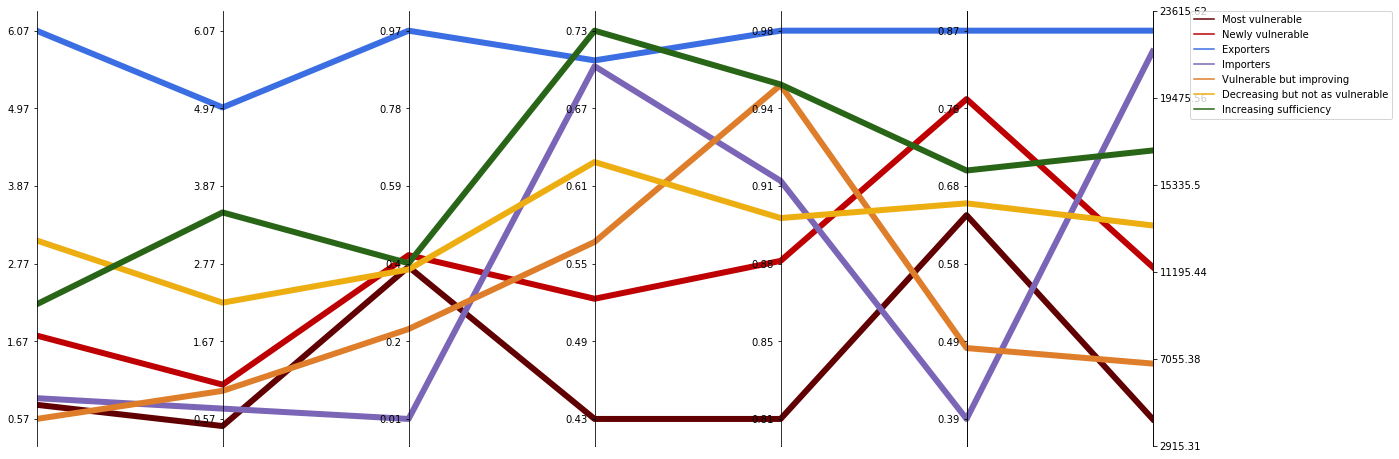

In [41]:
columns = ['CalSuff_2000', 'avg_new_suff', 'trade', 'GFSI', 'nutrition', 'water', 'GNP', 'Category']

plot_parallel_coord(averaged, columns, 'Category')

In [26]:
def plot_parallel_coord_all_countries(data, columns, index):
    cols = columns.copy()
    df = data[cols].copy()
    cols.remove(index)
    x = [i for i, _ in enumerate(cols)]
    colours = color_map

    # create dict of categories: colours
    colours = {cat_order[i]: colours[i] for i, _ in enumerate(cat_order)}


    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(20, 8))

    
    min_max_range = {}
    for col in cols:
        if col == 'CalSuff_2000':
            min_2000 = df['CalSuff_2000'].min()
            range_2000 = np.ptp(df['CalSuff_2000'])
        if col == 'avg_new_suff':
            min_max_range[col] = min_max_range['CalSuff_2000']
            df[col] = np.true_divide(df[col] - min_2000, range_2000)
        else:
            min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
            df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))
    
    # Plot each category
    for i, ax in enumerate(axes):
        for cat in cat_order:
            cat_points = df[df[index] == cat][cols]
            sns.lineplot(x*len(cat_points), cat_points.values.flatten(), linewidth=6, color=colours[cat], ax=ax, ci='sd', estimator='mean')
        ax.set_xlim([x[i], x[i+1]])
    

    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        col_name = cols[dim]
        if col_name == 'avg_new_suff':
            norm_min = df['CalSuff_2000'].min()
            norm_range = np.ptp(df['CalSuff_2000'])
            norm_step = norm_range / float(ticks-1)
        else:
            norm_min = df[cols[dim]].min()
            norm_range = np.ptp(df[cols[dim]])
            norm_step = norm_range / float(ticks-1)
            
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)
        
        ax.tick_params(axis='both', which='both', labelsize=20)


        
        """ax.yaxis.set_ticks([])
        ax.set_yticklabels([])"""
        
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        
    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=2)
        ax.set_xticklabels([cols[dim]])
        
        ax.xaxis.set_visible(False)
        

    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=2)
    ax.set_xticklabels([cols[-2], cols[-1]])
    
    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    """plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in set(df[index])],
        set(df[index]),
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
"""
    #plt.title("Values by category")

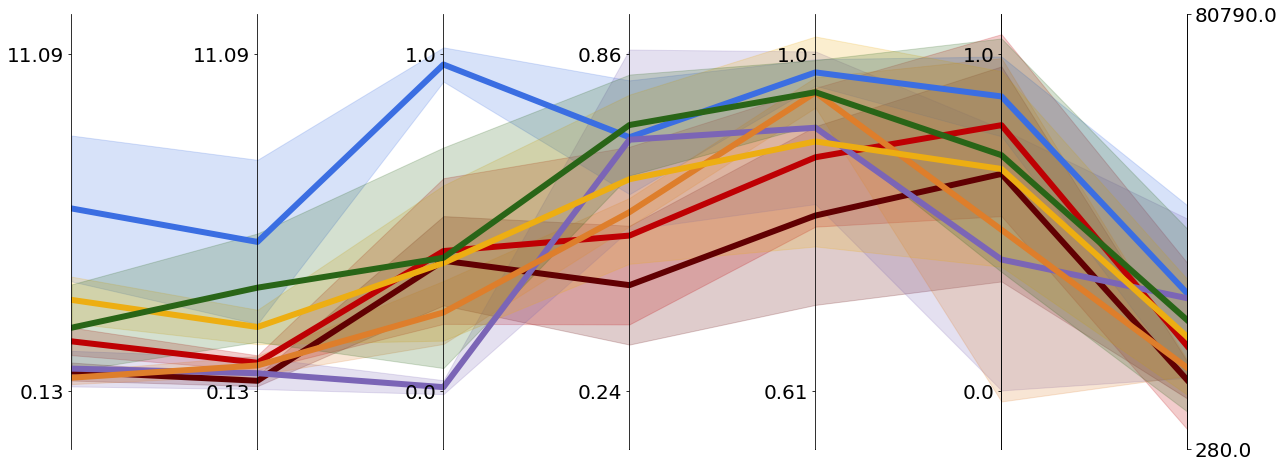

In [28]:
columns = ['CalSuff_2000', 'avg_new_suff', 'trade', 'GFSI', 'nutrition', 'water', 'GNP', 'Category']

all_countries = sufficiencies.set_index('Category').drop(['Highly variable']).reset_index()

plot_parallel_coord_all_countries(all_countries.reset_index(drop=True), columns, 'Category')
plt.savefig('Romain/figures/related_datasets/parallel_std.png', transparent=True, dpi=500)

In [14]:
all_countries[all_countries['Category'] == 'Exporters'].mean()

CalSuff_2000             6.072764
ssp1                     4.823800
ssp2                     5.069997
ssp3                     5.212209
ssp4                     5.334519
ssp5                     4.808679
delta_consistency        1.125000
trade                    0.969531
GFSI                     0.706250
GDP                  24480.904086
log_GDP                  9.715729
GNP                  23615.625000
log_GNP                  9.662490
water                    0.874538
nutrition                0.977200
avg_new_suff             5.049841
delta_CalSuff_avg       -1.022924
delta_max               -1.497573
lowest_ssp               4.280181
highest_ssp              5.773042
dtype: float64

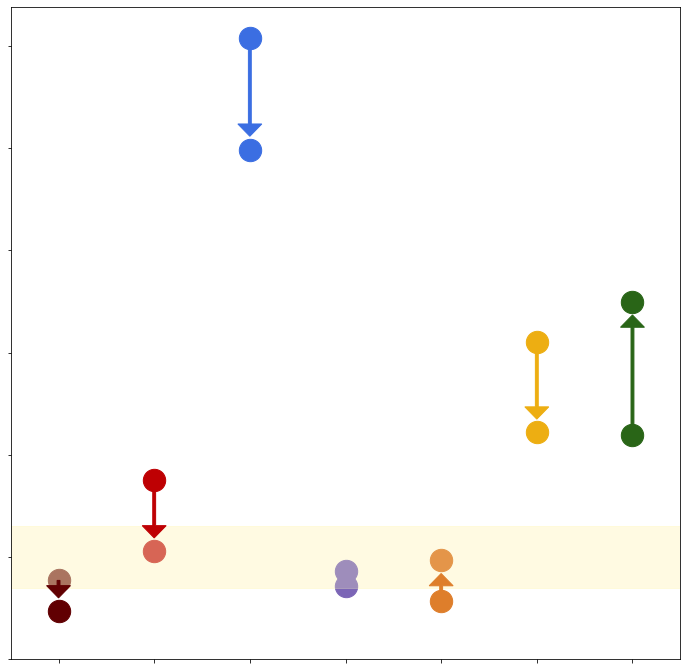

In [31]:
plt.figure(figsize=(12, 12))
plt.xlim(-0.5, len(averaged)-0.5)
plt.xticks(np.arange(len(averaged)), list(cat_order), rotation=20, fontsize=11)
plt.xticks(np.arange(len(averaged)), list([]))
#plt.ylabel('Average aloric sufficiency', fontsize=15)


for i, row in averaged.iterrows():
    colors = color_map
    plt.fill_between([-1, len(averaged)], 0.7, 1.3, color='lemonchiffon', alpha=0.1)
    if abs((row['avg_new_suff']-row['CalSuff_2000'])) > 0.3:
        plt.arrow(i, 
                  row['CalSuff_2000'], 
                  0, 
                  row['avg_new_suff']-row['CalSuff_2000'] - np.sign(row['avg_new_suff']-row['CalSuff_2000'])*0.25,
                  width=0.03, 
                  head_width=0.25, 
                  head_length=0.12, 
                  length_includes_head=False, 
                  alpha=1, 
                  color=colors[i])
    plt.scatter([i, i], row[['CalSuff_2000', 'avg_new_suff']], marker='o', label=row['Category'], s=500, c=colors[i])

    plt.yticks(np.arange(7), list([]))       

In [32]:
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return 2*h

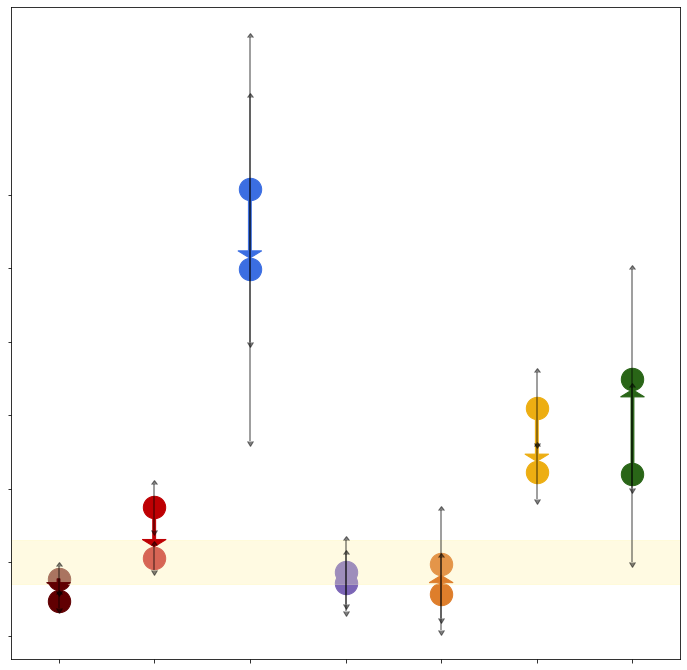

In [34]:
plt.figure(figsize=(12, 12))
plt.xlim(-0.5, len(averaged)-0.5)
plt.xticks(np.arange(len(averaged)), list(cat_order), rotation=20, fontsize=11)
plt.xticks(np.arange(len(averaged)), list([]))


for i, row in averaged.iterrows():
    colors = color_map
    plt.fill_between([-1, len(averaged)], 0.7, 1.3, color='lemonchiffon', alpha=0.1)
    if abs((row['avg_new_suff']-row['CalSuff_2000'])) > 0.3:
        plt.arrow(i, 
                  row['CalSuff_2000'], 
                  0, 
                  row['avg_new_suff']-row['CalSuff_2000'] - np.sign(row['avg_new_suff']-row['CalSuff_2000'])*0.25,
                  width=0.03, 
                  head_width=0.25, 
                  head_length=0.1, 
                  length_includes_head=False, 
                  alpha=1, 
                  color=colors[i])
    plt.scatter([i, i], row[['CalSuff_2000', 'avg_new_suff']], marker='o', label=row['Category'], s=500, c=colors[i])
    
    category = row['Category']
    length = confidence_interval(sufficiencies[sufficiencies['Category'] == category]['CalSuff_2000'], 0.9)
    plt.errorbar(i, row['CalSuff_2000'], length, uplims=True, lolims=True, ecolor='k', alpha=0.5)
    
    length = confidence_interval(sufficiencies[sufficiencies['Category'] == category]['avg_new_suff'], 0.9)
    plt.errorbar(i, row['avg_new_suff'], length, uplims=True, lolims=True, ecolor='k', alpha=0.5)
    
    plt.yticks(np.arange(7), list([]))       

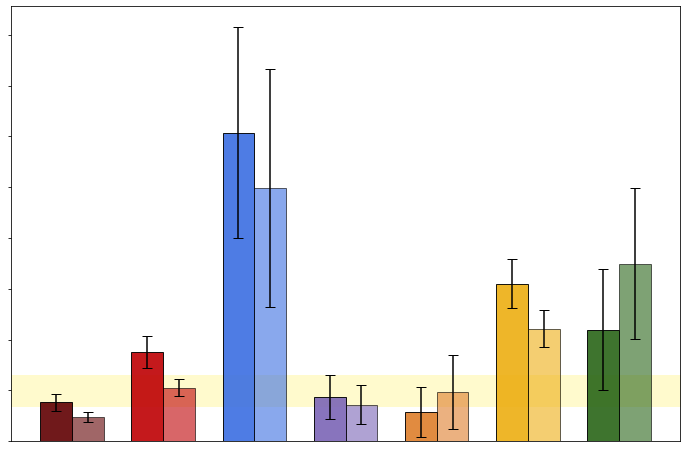

In [35]:
index = np.arange(len(cat_order))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-0.5, len(cat_order)+bar_width - 0.5)

intervals = [confidence_interval(sufficiencies[sufficiencies['Category'] == cat]['CalSuff_2000'], 0.9) for cat in cat_order]
actual = ax.bar(index, averaged['CalSuff_2000'].values, bar_width, yerr=intervals, capsize=5, color=color_map, edgecolor='k', alpha=0.9, label="Caloric sufficiency")

intervals = [confidence_interval(sufficiencies[sufficiencies['Category'] == cat]['avg_new_suff'], 0.9) for cat in cat_order]
future = ax.bar(index+bar_width, averaged['avg_new_suff'].values, bar_width, yerr=intervals, capsize=5, color=color_map, edgecolor='k', alpha=0.6, label="Future caloric sufficiency")

#ax.set_xlabel('Category')
#ax.set_ylabel('Incidence')
#ax.set_title('Crime incidence by season, type')
#ax.set_xticks(index + bar_width / 2)
ax.set_xticks([])
#ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.legend()

ax.fill_between([-0.5, len(averaged)], 0.7, 1.3, color='lemonchiffon')

## Some results

In [57]:
index = sufficiencies['trade'].dropna().index
pearsonr(sufficiencies.loc[index, 'CalSuff_2000'], sufficiencies.loc[index, 'trade'])

(0.6076000627969113, 4.233922275030364e-16)

In [58]:
index = sufficiencies['GFSI'].dropna().index
pearsonr(sufficiencies.loc[index, 'CalSuff_2000'], sufficiencies.loc[index, 'GFSI'])

(0.34200171016871134, 0.0002915363345719093)

In [59]:
index = sufficiencies['nutrition'].dropna().index
pearsonr(sufficiencies.loc[index, 'CalSuff_2000'], 1 - sufficiencies.loc[index, 'nutrition'])

(-0.2506596241091586, 0.004168468640365948)

In [62]:
sufficiencies.groupby('delta_consistency').count()['ISO3']/160

delta_consistency
0    0.5250
1    0.1125
2    0.1750
3    0.0625
4    0.1250
Name: ISO3, dtype: float64

In [137]:
sufficiencies.groupby('delta_consistency').count()['ISO3']

delta_consistency
0    84
1    18
2    28
3    10
4    20
Name: ISO3, dtype: int64

In [47]:
sufficiencies.groupby('Category')[['CalSuff_2000', 'avg_new_suff']].describe()

CalSuff_2000                                \
                                        count      mean       std       min   
Category                                                                      
Decreasing but not as vulnerable         28.0  3.100513  0.756332  2.129999   
Exporters                                16.0  6.072764  2.369943  3.276204   
Highly variable                          15.0  1.514558  0.637894  0.480220   
Importers                                21.0  0.865300  0.578383  0.128998   
Increasing sufficiency                   17.0  2.194842  1.408625  0.445256   
Most vulnerable                          35.0  0.771475  0.293254  0.134634   
Newly vulnerable                         24.0  1.752894  0.448668  1.272741   
Vulnerable but improving                  4.0  0.570959  0.208768  0.275438   

                                                                           \
                                       25%       50%       75%        max   
Category                                                                    
Decreasing but not as vulnerable  2.524827  2.821960  3.607842   4.575506   
Exporters                         3.924537  5.624477  7.668654  11.085546   
Highly variable                   1.077798  1.608818  1.791635   3.033127   
Importers                         0.378663  0.785374  1.166390   2.370509   
Increasing sufficiency            1.255245  1.617090  2.908651   5.270211   
Most vulnerable                   0.574239  0.785233  1.018292   1.170730   
Newly vulnerable                  1.479255  1.669084  1.914221   3.244740   
Vulnerable but improving          0.499586  0.636164  0.707538   0.736072   

                                 avg_new_suff                                \
                                        count      mean       std       min   
Category                                                                      
Decreasing but not as vulnerable         28.0  2.218807  0.560090  1.129393   
Exporters                                16.0  4.985210  2.667658  1.918092   
Highly variable                          15.0  1.650424  0.781672  0.791784   
Importers                                21.0  0.717401  0.513207  0.136715   
Increasing sufficiency                   17.0  3.497141  1.761541  1.478198   
Most vulnerable                          35.0  0.470577  0.173146  0.143785   
Newly vulnerable                         24.0  1.057040  0.241792  0.590899   
Vulnerable but improving                  4.0  0.969035  0.312151  0.717024   

                                                                           
                                       25%       50%       75%        max  
Category                                                                   
Decreasing but not as vulnerable  1.827296  2.215063  2.604703   3.311175  
Exporters                         3.715564  4.327628  5.707226  13.857385  
Highly variable                   0.930558  1.464707  2.144361   3.221626  
Importers                         0.350155  0.501535  0.955288   1.931472  
Increasing sufficiency            2.147442  2.967674  4.731768   7.044033  
Most vulnerable                   0.347216  0.477809  0.531190   0.994212  
Newly vulnerable                  0.915929  1.085589  1.197508   1.473523  
Vulnerable but improving          0.786255  0.870382  1.053163   1.418352